# Image Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](ここに以下の書式でURLを入れる) 
[![github](https://badgen.net/badge/:status/View%20On%20Github/black?icon=github&label)](https://github.com/AtomScott/SoccerTrack)
[![badge](https://img.shields.io/badge/launch-binder-579ACA.svg?logo=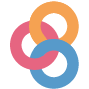)](https://)

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import soccertrack as st

dataset_path = st.datasets.get_path("wide_view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

root = st.utils.get_git_root()
cam = st.Camera(path_to_mp4)

# let's load the first frame of the video
frame = cam.get_frame(0)

## Show the models available

In [3]:
st.image_model.show_available_models()

['BaseTorchReIDModel', 'MLFN', 'MobileNetV2_x1_0', 'MobileNetV2_x1_4', 'OSNet_ain_x0_25', 'OSNet_ain_x0_5', 'OSNet_ain_x0_75', 'OSNet_ain_x1_0', 'OSNet_ibn_x1_0', 'OSNet_x0_25', 'OSNet_x0_5', 'OSNet_x0_75', 'OSNet_x1_0', 'ResNet50', 'ResNet50_fc512', 'ShuffleNet']


## Load a model

You can load a model by using the `load` function. The function searches subclasses of `BaseImageModel` for a match with the given name. If a match is found, an instance of the model is returned. If no match is found, a warning is logged and the function returns None. 

There are three arguments to the `load` function:
* model_name: The name of the model to load. This is the name of the class, not the name of the file. It is not case sensitive.
* model_config: A dictionary containing the configuration for the model.
* inference_config: A dictionary containing the configuration for the inference engine.

In [4]:
im_model = st.image_model.load(model_name="ResNet50_fc512")

# You can check the current configuration with the following methods:
im_model.show_inference_config()
im_model.show_model_config()

show_inference_config:0215  💬| Inference configuration: 
show_model_config:0210  💬| Model configuration: 
show_model_config:0212  💬|   name: resnet50_fc512 
show_model_config:0212  💬|   path: https://drive.google.com/file/d/1fDJLcz4O5wxNSUvImIIjoaIF9u1Rwaud/view?usp=sharing 
show_model_config:0212  💬|   device: cpu 
show_model_config:0212  💬|   image_size: (256, 128) 
show_model_config:0212  💬|   pixel_mean: [0.485, 0.456, 0.406] 
show_model_config:0212  💬|   pixel_std: [0.229, 0.224, 0.225] 
show_model_config:0212  💬|   pixel_norm: True 
show_model_config:0212  💬|   verbose: False 


## Run Embedding on a single image

The input to the model should be flexible. It accepts numpy.ndarray, torch.Tensor, pathlib Path, string file, PIL Image, or a list of any of these. All inputs will be converted to a list of numpy arrays representing the images.

The output of the model is expected to be a two dimensional numpy array. The first dimension is the number of images in the input. The second dimension is the number of features in the embedding.

In [5]:
x = im_model(frame)
print(x.shape, x.dtype)

torch.Size([1, 512]) torch.float32


## Run detection on multiple images (batched input)

In [6]:
x = im_model([frame, frame, frame, frame])
print(x.shape, x.dtype)

torch.Size([4, 512]) torch.float32


## Run on a Detection Object

One common use case for image embedding in tracking is to extract image features from a detected bounding box. The `Detection` object is a simple class that contains a bounding box and an image. The `Detection` object can be used as input to the `embed_detections` function.

In [7]:
det_model = st.detection_model.load(model_name="yolov5s")
detections = det_model(frame, size=960)[0]

embeddings = im_model.embed_detections(detections, frame)

print(detections.to_df())
print(embeddings.shape)

Using cache found in /Users/atom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-15 torch 1.13.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


     bbox_left    bbox_top  bbox_width  bbox_height      conf  class
0  3466.608887  796.144043   57.977783   102.286011  0.521880    0.0
1  2834.737305  589.656494   26.984131    55.704590  0.398783    0.0
2  3062.117920  600.184692   30.535645    46.639404  0.337920    0.0
(3, 512)


## Running a custom model

Running a model with a custom architecture is easy. You just need to create a subclass of BaseImageModel and implement the `load` and `forward` methods, and then add `ConfigTemplates` for your model. See how this is done in the `BaseTorchReIDModel` model.

## Tests

In [8]:
!poetry run pytest {root}/tests/test_image_model --verbose

============================= test session starts ==============================
platform darwin -- Python 3.10.11, pytest-7.2.1, pluggy-1.0.0 -- /Users/atom/Library/Caches/pypoetry/virtualenvs/soccertrack-KNSgM8DD-py3.10/bin/python
cachedir: .pytest_cache
rootdir: /Users/atom/Github/SoccerTrack
plugins: typeguard-2.13.3, anyio-3.6.2
collected 0 items                                                              

============================ no tests ran in 0.00s =============================
ERROR: file or directory not found: /Users/atom/Github/SoccerTrack/tests/test_image_model

